# Creating a dataloader and pre-processing our data

## 0. Before we start

This notebook is used to demonstrate how to create a dataloader on a **mock** dataset, which resembles the one, which will be used for the small project in the SUTD 50.039 Deep Learning class (Y2021).

This notebook intends to demonstrate a way to create dataloaders from scratch, i.e. just a folder containing several images, so that it can later be fed into our PyTorch model.

It consists of four parts:
1. Getting familiar with the demo dataset and the images it contains.
2. Creating a dataset object in general, and later, specific ones for training, testing and validation datasets.7
3. Using torch to transform said dataset into a dataloader,
4. and later use the said DataLoader in the training of a simple PyTorch model.

It relies on the following libraries:
- Matplotlib for displaying images in matplotlib plots,
- Numpy for numerical operations on tensors/arrays,
- Pillow (PIL) for opening images,
- and torch/torchvision for typical operations on tensors, datasets and dataloaders.

In [1]:
import collections
import glob
import random

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

MAIN = __name__ == "__main__"

## 1. Getting familiar with the dataset

The images stored in the **./dataset_demo** folder and its subfolder consists of 150 by 150 pixels greyscale images, representing X-Ray pictures of lungs. 

In [2]:
if MAIN:
    get_ipython().system('tree dataset -d')

dataset
├── test
│   ├── infected
│   │   ├── covid
│   │   └── non-covid
│   └── normal
├── train
│   ├── infected
│   │   ├── covid
│   │   └── non-covid
│   └── normal
└── val
    ├── infected
    │   ├── covid
    │   └── non-covid
    └── normal

15 directories


In [3]:
dataset_folder = "dataset"

In [4]:
data_split_paths = {
    "train": "./{}/train/".format(dataset_folder),
    "val": "./{}/val/".format(dataset_folder),
    "test": "./{}/test/".format(dataset_folder),
}

In [5]:
class_paths = {
    "normal": "/normal/",
    "non-covid": "/infected/non-covid/",
    "covid": "/infected/covid/"
}

In [6]:
classification_types = {
    "normal/infected": [['normal'], ['non-covid', 'covid']],
    "covid/non-covid": [['covid'], ['non-covid']],
    "normal/non-covid/covid": [['normal'], ['non-covid'], ['covid']]
}

In [7]:
class Lung_Dataset(Dataset):
    
    def __init__(self, data_split, classification_type):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        if data_split in data_split_paths:
            data_split_path = data_split_paths[data_split]
        else:
            print("data_split should be either of {}".format(data_split_paths.keys()))
            raise ValueError
        
        if classification_type in classification_types:
            classes = classification_types[classification_type]
        else:
            print("classification_type should be either of {}".format(classification_types.keys()))
            raise ValueError
        
        self.filepaths_and_labels = []
        for label,class_ in enumerate(classes):
            for subclass in class_:
                filepath_pattern = data_split_path + class_paths[subclass] + "*.jpg"
                for filepath in glob.glob(filepath_pattern):
                    self.filepaths_and_labels.append((filepath, label))    
    
        self.data_split = data_split
        self.classification_type = classification_type
        self.classes = classes

    
    def __str__(self):
        """
        __str__ special method, usage print(object)
        Print type and description
        """
        c = collections.Counter(label for filepath,label in self.filepaths_and_labels)
        class_distbn = [c[index] for index in range(len(self.classes))]
        
        msg = ""
        msg += "Type of object: {}\n".format(type(self))
        msg += "Data Split: {}\n".format(self.data_split)
        msg += "Classification Type: {}\n".format(self.classification_type)
        msg += "Available Classes: {}\n".format(self.classes)
        msg += "Class Distribution: {}\n".format(class_distbn)
        msg += "Total Dataset Size: {}".format(len(self))
        return msg
        
    
    def __len__(self):
        """
        __len__ special method, usage len(object)
        Returns the number of images in dataset
        """
        return len(self.filepaths_and_labels)

    
    def __getitem__(self, index):
        """
        __getitem__ special method, usage: object[index]
        Returns the image of torch.Size([1, 150, 150]) and its integer label
        """
        
        filepath, label = self.filepaths_and_labels[index]
        
        with open(filepath, 'rb') as f:
            # Convert to Numpy array and normalize pixel values by dividing by 255.
            im = np.asarray(Image.open(f))/255
        
        im = transforms.functional.to_tensor(np.array(im)).float()
        
        # shiying to include various random transforms here
        # take Tensor of torch.Size([1, 150, 150]) and return the same

        return im, label
    
    def show_img(self, index):
        im, label = self[index]
        plt.imshow(im[0,:,:])
        plt.title("Label {} {}".format(label, self.classes[label]))
        plt.show()
        plt.close()

Type of object: <class '__main__.Lung_Dataset'>
Data Split: train
Classification Type: normal/infected
Available Classes: [['normal'], ['non-covid', 'covid']]
Class Distribution: [1341, 3875]
Total Dataset Size: 5216


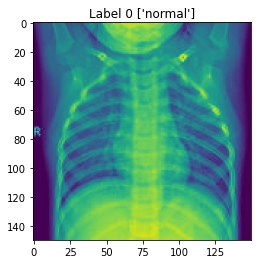

In [8]:
if MAIN:
    ld_train = Lung_Dataset("train", "normal/infected")
    print(ld_train)
    ld_train.show_img(1)

## 3. Creating a Dataloader object

The final step is to create Dataloaders, based on our previous Dataset objects. These Dataloaders will later be used for training, testing and evaluating our models in PyTorch.

The dataloaders can be simply created by using the DataLoader object from the torch.utils.data library, and by simply passing it our Dataset object. Additional parameters such as the batch_size (set to 4 for demo here) can be specified. Another interesting parameter is the shuffle = True one, which will randomly shuffle the order in which the images are selected in the Dataset.

Additional parameters for the DataLoader can be specified (see https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader for details), but it will not be necessary for this small project.

In [9]:
# Batch size value to be used (to be decided freely, but set to 4 for demo)
bs_val = 4

In [10]:
# Dataloader from dataset (train)
if MAIN:
    train_loader = DataLoader(ld_train, batch_size = bs_val, shuffle = True)
    print(train_loader)

In [11]:
# Dataloader from dataset (test and val)
if MAIN: 
    ld_test = Lung_Dataset("test", "normal/infected")
    test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
    print(test_loader)

if MAIN:
    ld_val = Lung_Dataset("val", "normal/infected")
    val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)
    print(val_loader)

During the training, you will call for mini-batches using a for loop of some sort, probably similar to the one below.

Notice how each iteration of the for loop below produces a torch tensor of size [1, bs_val, 150, 150] in v[0] containing the bs_val = 4 images in the current mini-batch. You also have, in v[1], a torch tensor of size [bs_val, 2], containing the one hot vectors for each of the bs_val = 4 images.

We voluntarily interrupt it after one iteration of the mini-batch using an assert False.

In [12]:
# Typical mini-batch for loop on dataloader (train)
if MAIN: 
  for k, v in enumerate(train_loader):
    print("-----")
    print(k)
    print(v[0])
    print(v[1])
    # Forced stop
    break
    #assert False, "Forced stop after one iteration of the for loop"

-----
0
tensor([[[[0.2980, 0.3020, 0.3137,  ..., 0.3098, 0.3412, 0.3216],
          [0.2980, 0.3020, 0.3137,  ..., 0.5216, 0.5373, 0.4549],
          [0.2941, 0.2980, 0.3059,  ..., 0.4980, 0.6510, 0.4941],
          ...,
          [0.0078, 0.0039, 0.0000,  ..., 0.4902, 0.4902, 0.2000],
          [0.0078, 0.0039, 0.0000,  ..., 0.1451, 0.1765, 0.0000],
          [0.0039, 0.0039, 0.0000,  ..., 0.0118, 0.0000, 0.0353]]],


        [[[0.1765, 0.2118, 0.2353,  ..., 0.1137, 0.0863, 0.0667],
          [0.1882, 0.2157, 0.2353,  ..., 0.1137, 0.0824, 0.0549],
          [0.2039, 0.2196, 0.2353,  ..., 0.1216, 0.0980, 0.0784],
          ...,
          [0.0627, 0.0431, 0.1569,  ..., 0.0941, 0.0941, 0.0941],
          [0.0627, 0.0471, 0.1608,  ..., 0.0941, 0.0941, 0.0941],
          [0.0627, 0.0471, 0.1647,  ..., 0.0941, 0.0941, 0.0941]]],


        [[[0.1451, 0.1882, 0.2275,  ..., 0.0549, 0.0510, 0.0510],
          [0.1961, 0.2157, 0.2510,  ..., 0.0510, 0.0510, 0.0471],
          [0.2549, 0.2431, 0.2

## 4. Using our dataloader for training a model

We can then use our custom dataloader for training a model.
If we decide to create a model as a subclass of the nn.Module of PyTorch, and later write a train function, as in this Notebook shown in class (https://colab.research.google.com/drive/1zhDmMfSFBy3clH-NRp9nXruQXnckZ3X1#scrollTo=KZd049wKyFT8), then our train_loader object defined in Section 3., can be directly fed to our train function in place of the train_loader.

We could for instance, define a simple (probably too simple!) model below.

In [13]:
# A simple mode
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2D: 1 input channel, 8 output channels, 3 by 3 kernel, stride of 1.
        self.conv1 = nn.Conv2d(1, 4, 3, 1)
        self.fc1 = nn.Linear(87616, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = F.log_softmax(x, dim = 1)
        return output

In [14]:
# Create model
if MAIN:
    model = Net()

Later on, we will probably have to write a train function, which will implement a mini-batch loop, which resembles the one below. It will simply iterate on the DataLoader we have defined earlier.

In [15]:
# Try model on one mini-batch
if MAIN: 
  for batch_idx, (images_data, target_labels) in enumerate(train_loader):
    predicted_labels = model(images_data)
    print(predicted_labels)
    print(target_labels)
    # Forced stop
    break
    #assert False, "Forced stop after one iteration of the mini-batch for loop"

tensor([[-0.7813, -0.6122],
        [-0.8797, -0.5360],
        [-0.8091, -0.5893],
        [-0.8234, -0.5779]], grad_fn=<LogSoftmaxBackward>)
tensor([1, 1, 0, 1])


## 5. What is next?

You will have to download the full pictures repository, as specified in the Small Project instruction PDF. It will contain a much larger dataset, for which you will have to write a DataLoader. You may reuse parts of the codes presented in this notebook to come up with your custom DataLoader, if necessary.

Later on, you will have to train a model for classification, as suggested in the Small Project PDF!
Good luck!

In [16]:
if MAIN:
    get_ipython().system('jupyter nbconvert --to script lung_dataset.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook lung_dataset.ipynb to script
[NbConvertApp] Writing 9924 bytes to lung_dataset.py
